In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import scale, normalize


In [2]:
normalization = True
def normalize_features(X, lpc_max_order):
    norm_X = np.zeros(X.shape)
    n_features = X.shape[1]
    n_skip = n_features // lpc_max_order
    for f in np.arange(n_features):
        norm_X[:, f::n_skip] = normalize(X[:, f::n_skip], axis=1)
    return norm_X

### Extract train features

In [30]:
train_algs = ['A01', 'A02', 'A03', 'A04', 'A05', 'A06']

X_train_bonafide_list = []
X_train_spoof_list = []
max_lpc_order = 50
lpc_lengths = np.arange(1, max_lpc_order + 1)

train_alg = {}

gain_log_scale = True
for alg in train_algs
    for l in lpc_lengths:
        train_features = pd.read_pickle('/nas/home/cborrelli/bot_speech/features/lpc/train_LPC_' + str(l) +'.pkl')
        #train_features.drop('coeff', axis=1, inplace=True)
        train_features = train_features[(train_features['system_id']==alg)]
        train_features.dropna(inplace=True)

        train_bonafide_features = train_features[train_features['label']=='bonafide']
        train_spoof_features = train_features[train_features['label']=='spoof']

        if l==1:
            train_spoof_features = train_features[train_features['label']=='spoof'].sample(
                n=train_bonafide_features.shape[0])
            selected_files = train_spoof_features['audio_filename']
        else:
            train_spoof_features = train_spoof_features[train_spoof_features['audio_filename'].isin(selected_files)]
        X_train_bonafide_list.append(np.array(train_bonafide_features['lpc_res_mean']).reshape((-1, 1)))
        X_train_bonafide_list.append(np.array(train_bonafide_features['lpc_res_max']).reshape((-1, 1)))
        X_train_bonafide_list.append(np.array(train_bonafide_features['lpc_res_min']).reshape((-1, 1)))
        X_train_bonafide_list.append(np.array(train_bonafide_features['lpc_res_var']).reshape((-1, 1)))
        X_train_spoof_list.append(np.array(train_spoof_features['lpc_res_mean']).reshape((-1, 1)))
        X_train_spoof_list.append(np.array(train_spoof_features['lpc_res_max']).reshape((-1, 1)))
        X_train_spoof_list.append(np.array(train_spoof_features['lpc_res_min']).reshape((-1, 1)))
        X_train_spoof_list.append(np.array(train_spoof_features['lpc_res_var']).reshape((-1, 1)))

        if gain_log_scale == False:
            X_train_bonafide_list.append(np.array(train_bonafide_features['lpc_gain_max']).reshape((-1, 1)))
            X_train_bonafide_list.append(np.array(train_bonafide_features['lpc_gain_min']).reshape((-1, 1)))
            X_train_bonafide_list.append(np.array(train_bonafide_features['lpc_gain_mean']).reshape((-1, 1)))
            X_train_bonafide_list.append(np.array(train_bonafide_features['lpc_gain_var']).reshape((-1, 1)))
            X_train_spoof_list.append(np.array(train_spoof_features['lpc_gain_max']).reshape((-1, 1)))
            X_train_spoof_list.append(np.array(train_spoof_features['lpc_gain_min']).reshape((-1, 1)))
            X_train_spoof_list.append(np.array(train_spoof_features['lpc_gain_mean']).reshape((-1, 1)))
            X_train_spoof_list.append(np.array(train_spoof_features['lpc_gain_var']).reshape((-1, 1)))
        else:
            X_train_bonafide_list.append(np.log10(np.array(train_bonafide_features['lpc_gain_max']).reshape((-1, 1))))
            X_train_bonafide_list.append(np.log10(np.array(train_bonafide_features['lpc_gain_min']).reshape((-1, 1))))
            X_train_bonafide_list.append(np.log10(np.array(train_bonafide_features['lpc_gain_mean']).reshape((-1, 1))))
            X_train_bonafide_list.append(np.log10(np.array(train_bonafide_features['lpc_gain_var']).reshape((-1, 1))))
            X_train_spoof_list.append(np.log10(np.array(train_spoof_features['lpc_gain_max']).reshape((-1, 1))))
            X_train_spoof_list.append(np.log10(np.array(train_spoof_features['lpc_gain_min']).reshape((-1, 1))))
            X_train_spoof_list.append(np.log10(np.array(train_spoof_features['lpc_gain_mean']).reshape((-1, 1))))
            X_train_spoof_list.append(np.log10(np.array(train_spoof_features['lpc_gain_var']).reshape((-1, 1))))


In [31]:
X_train_bonafide = np.concatenate(X_train_bonafide_list, axis=1)
X_train_spoof = np.concatenate(X_train_spoof_list, axis=1)
X_train = np.concatenate((X_train_bonafide, X_train_spoof), axis=0)

In [25]:
train_features.columns

Index(['start_voice', 'end_voice', 'lpc_res_mean', 'lpc_res_max',
       'lpc_res_min', 'lpc_res_var', 'lpc_gain_mean', 'lpc_gain_max',
       'lpc_gain_min', 'lpc_gain_var', 'ltp_res_mean', 'ltp_res_max',
       'ltp_res_min', 'ltp_res_var', 'ltp_gain_mean', 'ltp_gain_max',
       'ltp_gain_min', 'ltp_gain_var', 'speaker_id', 'audio_filename',
       'system_id', 'label'],
      dtype='object')

In [32]:
train_features

,start_voice,end_voice,lpc_res_mean,lpc_res_max,lpc_res_min,lpc_res_var,lpc_gain_mean,lpc_gain_max,lpc_gain_min,lpc_gain_var,...,ltp_res_min,ltp_res_var,ltp_gain_mean,ltp_gain_max,ltp_gain_min,ltp_gain_var,speaker_id,audio_filename,system_id,label
0,7680.0,54719.0,0.000137,0.021835,-0.027288,0.000137,626.730245,8217.439043,1.404993,2.462253e+06,...,-0.016340,0.000101,1.266452,4.027678,1.068358,0.131375,LA_0079,LA_T_1138215,-,bonafide
1,8160.0,67679.0,0.000070,0.016139,-0.019598,0.000070,2838.673282,170116.404878,1.235620,2.191384e+08,...,-0.011847,0.000058,1.220221,4.706324,1.041708,0.068551,LA_0079,LA_T_1271820,-,bonafide
2,18240.0,42239.0,0.000141,0.024620,-0.029850,0.000141,272.325103,4390.400155,1.647057,5.828478e+05,...,-0.016302,0.000097,1.246960,3.434502,1.079782,0.130723,LA_0079,LA_T_1272637,-,bonafide
3,6720.0,44639.0,0.000104,0.024322,-0.030141,0.000104,2480.652489,60329.141291,1.914692,7.081267e+07,...,-0.019430,0.000088,1.248164,3.151442,1.062743,0.073647,LA_0079,LA_T_1276960,-,bonafide
4,9120.0,52799.0,0.000168,0.027242,-0.032055,0.000168,938.292869,8807.734576,1.095756,4.183358e+06,...,-0.021293,0.000145,1.186312,3.422221,1.062075,0.037548,LA_0079,LA_T_1341447,-,bonafide
5,18240.0,34559.0,0.000139,0.024550,-0.033116,0.000139,93.860977,801.750230,2.276194,1.906974e+04,...,-0.021625,0.000112,1.210358,2.181834,1.055357,0.035590,LA_0079,LA_T_1363611,-,bonafide
6,6720.0,33119.0,0.000058,0.017676,-0.022900,0.000058,639.877318,8288.169327,1.458398,2.217561e+06,...,-0.013023,0.000044,1.249128,2.653719,1.073408,0.053464,LA_0079,LA_T_1596451,-,bonafide
7,8640.0,31199.0,0.000080,0.018198,-0.026299,0.000080,90.918112,582.533927,1.671713,1.496035e+04,...,-0.014314,0.000061,1.323803,6.921853,1.061492,0.353750,LA_0079,LA_T_1608170,-,bonafide
8,8640.0,37919.0,0.000434,0.037348,-0.043968,0.000434,2360.828610,90585.612126,1.925676,1.507585e+08,...,-0.021709,0.000180,1.576451,20.308203,1.065591,3.477495,LA_0079,LA_T_1684951,-,bonafide
9,6240.0,47519.0,0.000082,0.021962,-0.029128,0.000082,971.243284,41238.120295,1.529389,2.036393e+07,...,-0.016255,0.000062,1.272755,4.870164,1.068648,0.178039,LA_0079,LA_T_1699801,-,bonafide


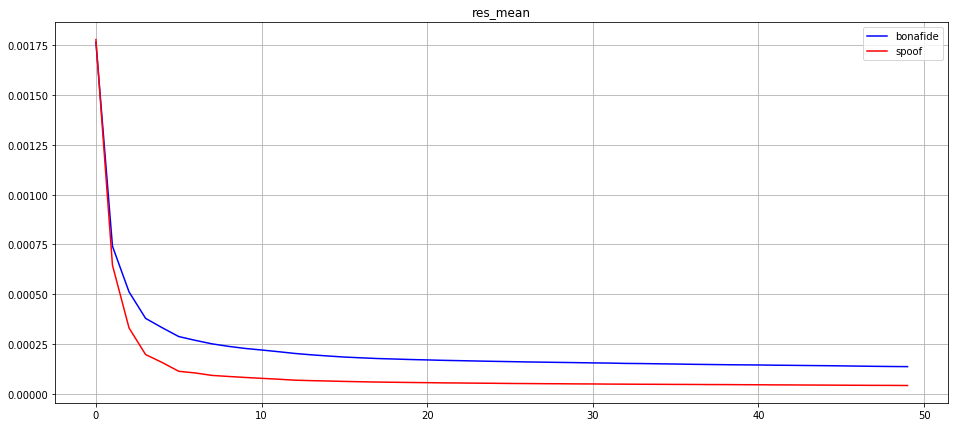

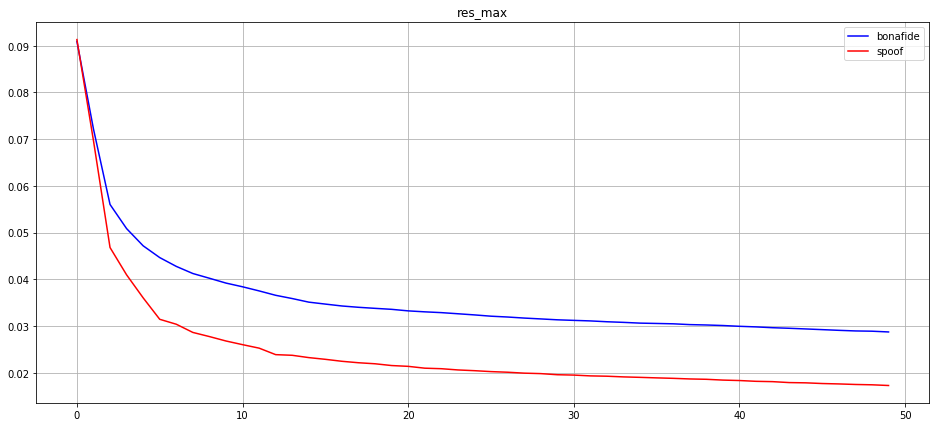

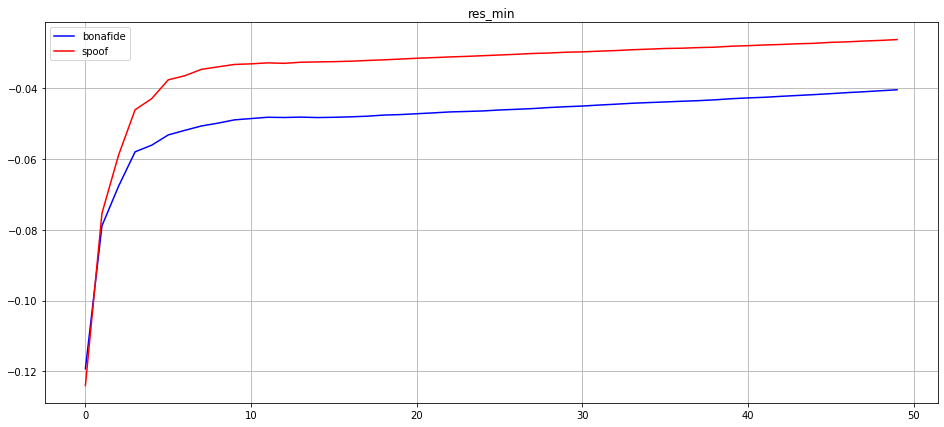

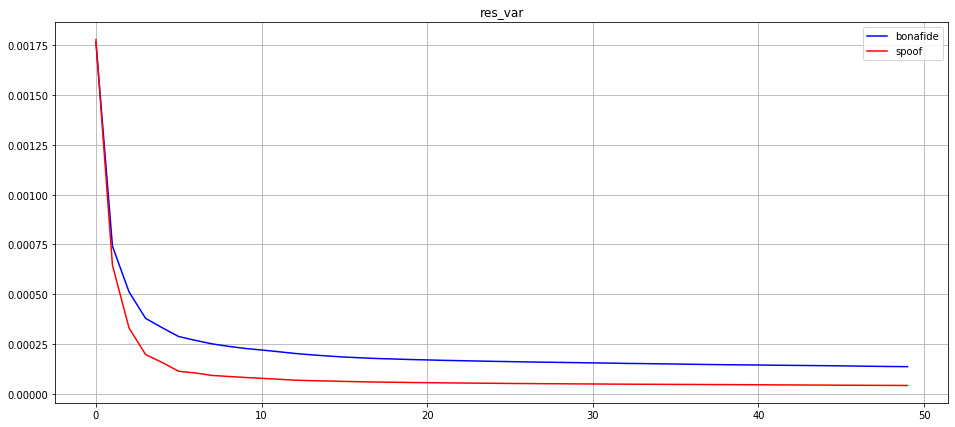

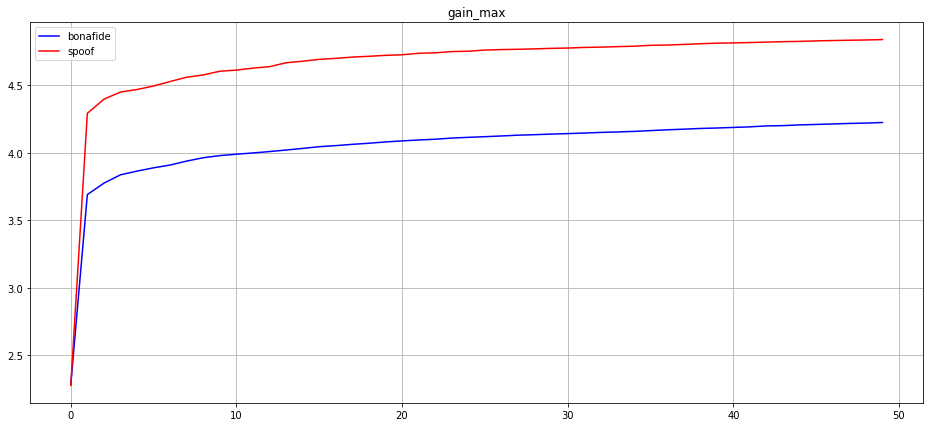

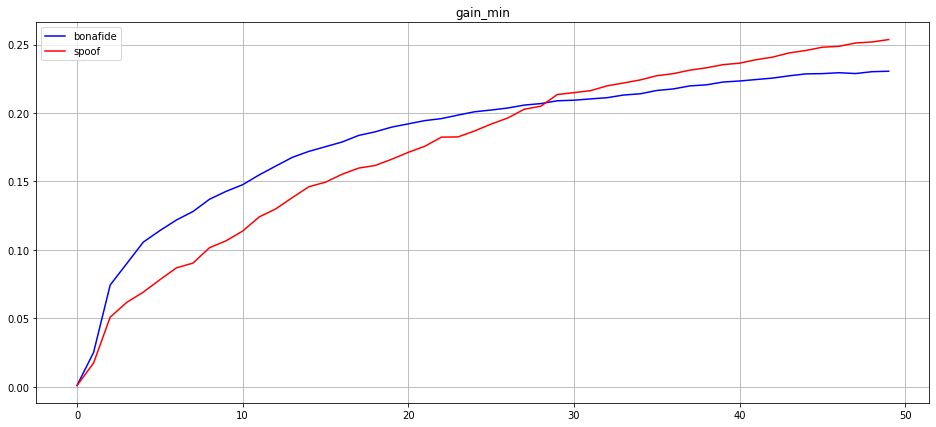

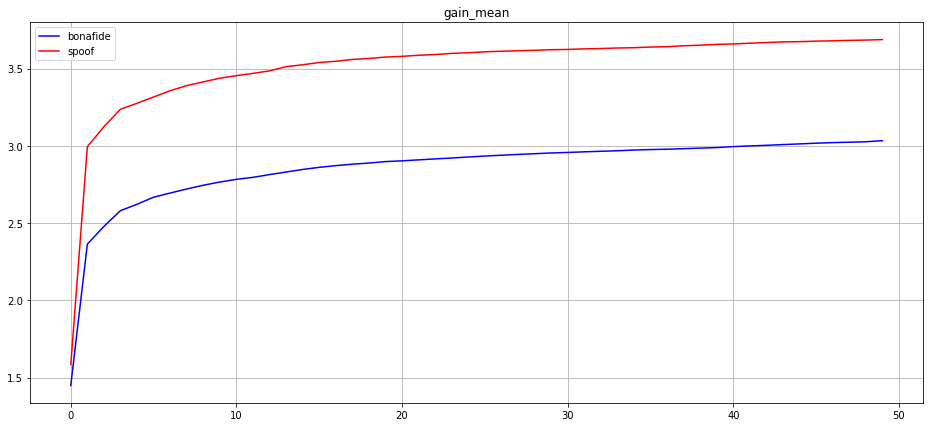

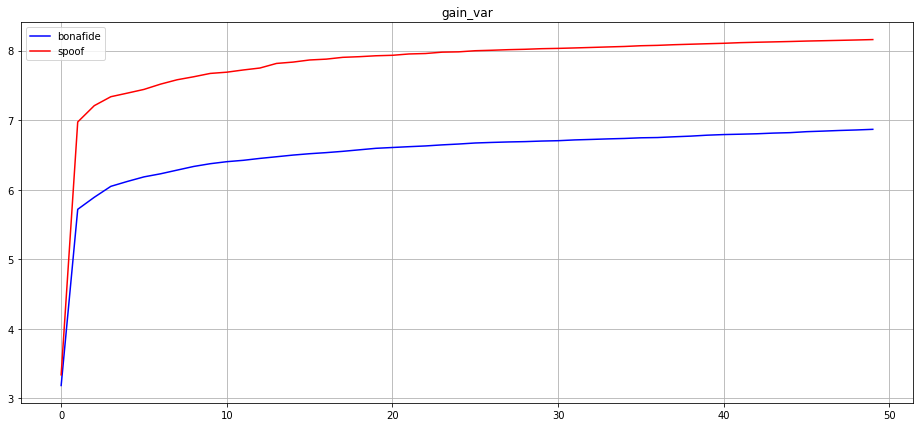

In [34]:
for i in np.arange(8):
    plt.figure(figsize=(16,7))
    feature_index = i
    plt.plot(np.nanmedian(X_train_bonafide[:, feature_index::8], axis=0), color='blue', label='bonafide')
    plt.plot(np.nanmedian(X_train_spoof[:, feature_index::8], axis=0), color='red',label='spoof')
    plt.legend()
    plt.title(feature_list[i])
    plt.grid()

ValueError: supplied range of [-inf, -4.470828115986923] is not finite

<Figure size 1152x504 with 0 Axes>

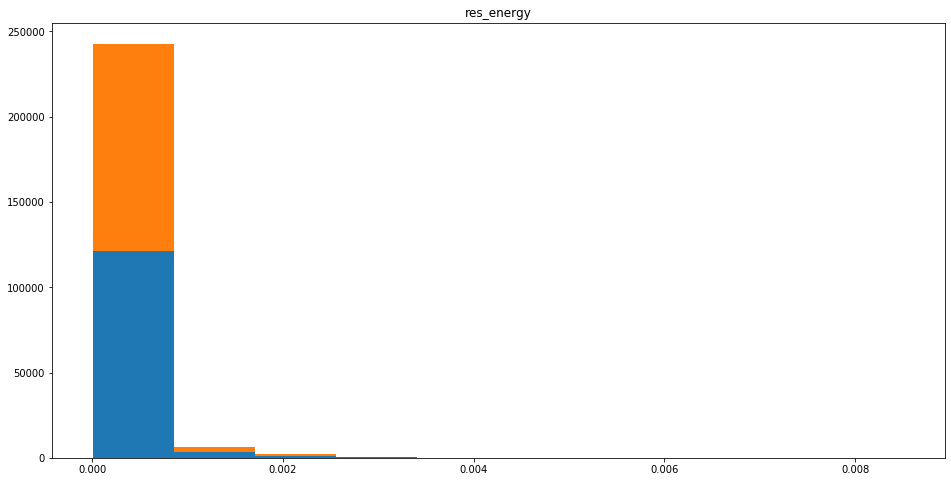

<Figure size 1152x504 with 0 Axes>

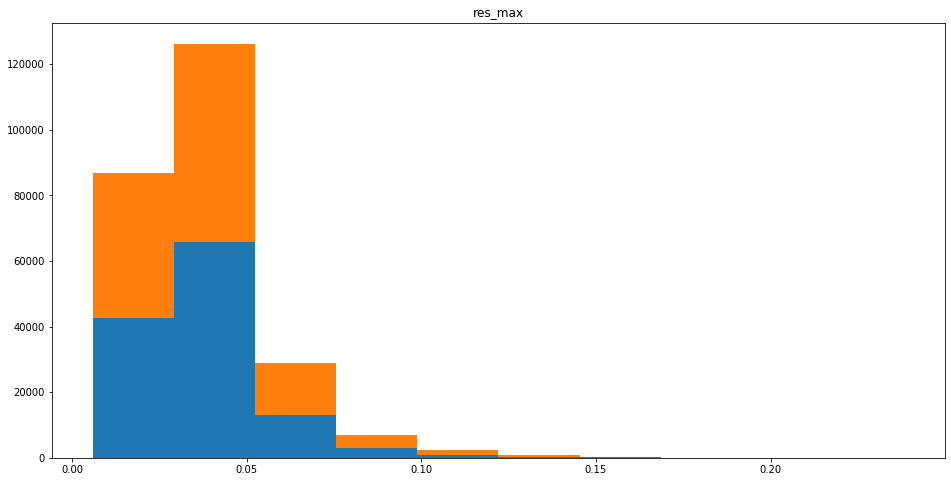

<Figure size 1152x504 with 0 Axes>

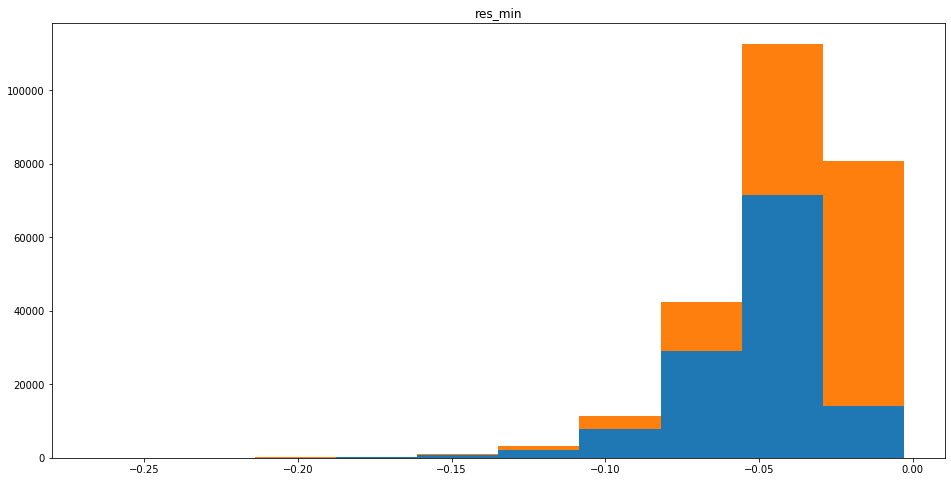

<Figure size 1152x504 with 0 Axes>

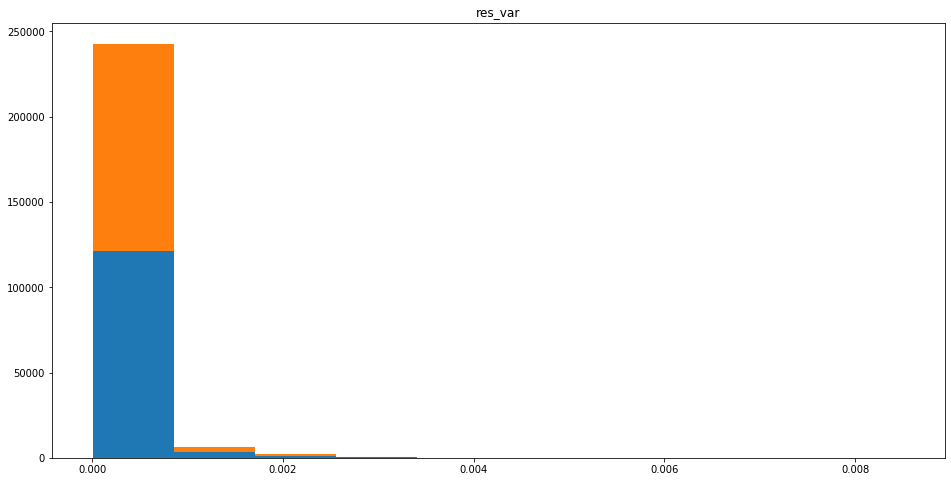

<Figure size 1152x504 with 0 Axes>

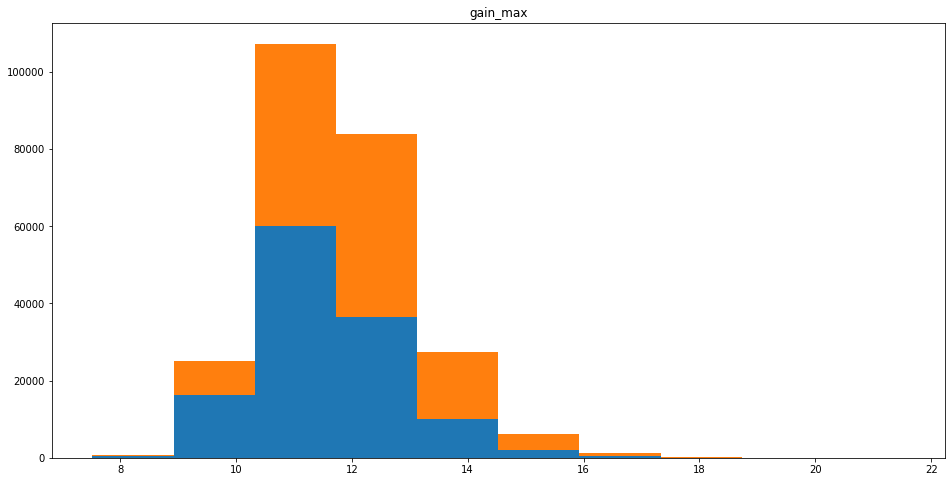

<Figure size 1152x504 with 0 Axes>

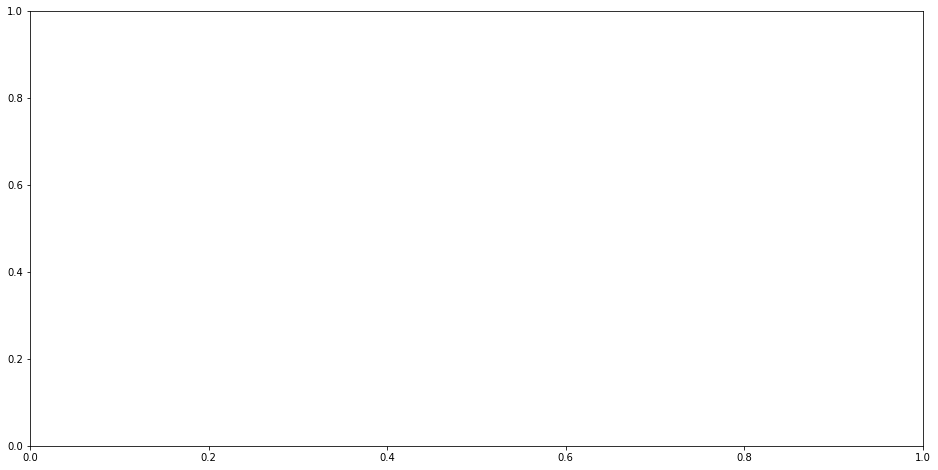

In [7]:
for i in np.arange(8):
    plt.figure(figsize=(16,7))
    feature_index = i
    plt.figure(figsize=(16,8))
    plt.hist([X_train_bonafide[:, feature_index::8].reshape(-1), X_train_spoof
                             [:, feature_index::8].reshape(-1)], stacked=True)
    plt.title(feature_list[i])


In [ ]:
X_train_bonafide[:, feature_index::8].shape

### Extract dev features

In [ ]:
X_dev_bonafide_list = []
X_dev_spoof_list = []

for l in lpc_lengths:
    dev_features = pd.read_pickle('/nas/home/cborrelli/bot_speech/features/dev_LPC_' + str(l) +'.pkl')
    dev_features.drop('coeff', axis=1, inplace=True)
    dev_features.dropna(inplace=True)  
    
    dev_bonafide_features = dev_features[dev_features['label']=='bonafide']
    dev_spoof_features = dev_features[dev_features['label']=='spoof']
    
    if l==1:
        dev_spoof_features = dev_features[dev_features['label']=='spoof'].sample(n=dev_bonafide_features.shape[0])
        selected_files = dev_spoof_features['audio_filename']
    else:
        dev_spoof_features = dev_spoof_features[dev_spoof_features['audio_filename'].isin(selected_files)]
    
    X_dev_bonafide_list.append(np.array(dev_bonafide_features['res_energy']).reshape((-1, 1)))
    X_dev_bonafide_list.append(np.array(dev_bonafide_features['res_max']).reshape((-1, 1)))
    X_dev_bonafide_list.append(np.array(dev_bonafide_features['res_min']).reshape((-1, 1)))
    X_dev_bonafide_list.append(np.array(dev_bonafide_features['res_var']).reshape((-1, 1)))
    
    X_dev_spoof_list.append(np.array(dev_spoof_features['res_energy']).reshape((-1, 1)))
    X_dev_spoof_list.append(np.array(dev_spoof_features['res_max']).reshape((-1, 1)))
    X_dev_spoof_list.append(np.array(dev_spoof_features['res_min']).reshape((-1, 1)))
    X_dev_spoof_list.append(np.array(dev_spoof_features['res_var']).reshape((-1, 1)))
    
    if  if gain_log_scale == False:
        X_dev_bonafide_list.append(np.array(dev_bonafide_features['gain_max']).reshape((-1, 1)))
        X_dev_bonafide_list.append(np.array(dev_bonafide_features['gain_min']).reshape((-1, 1)))
        X_dev_bonafide_list.append(np.array(dev_bonafide_features['gain_mean']).reshape((-1, 1)))
        X_dev_bonafide_list.append(np.array(dev_bonafide_features['gain_var']).reshape((-1, 1)))

        X_dev_spoof_list.append(np.array(dev_spoof_features['gain_max']).reshape((-1, 1)))
        X_dev_spoof_list.append(np.array(dev_spoof_features['gain_min']).reshape((-1, 1)))
        X_dev_spoof_list.append(np.array(dev_spoof_features['gain_mean']).reshape((-1, 1)))
        X_dev_spoof_list.append(np.array(dev_spoof_features['gain_var']).reshape((-1, 1)))
    else:
        X_dev_bonafide_list.append(np.log10(np.array(dev_bonafide_features['gain_max']).reshape((-1, 1))))
        X_dev_bonafide_list.append(np.log10(np.array(dev_bonafide_features['gain_min']).reshape((-1, 1))))
        X_dev_bonafide_list.append(np.log10(np.array(dev_bonafide_features['gain_mean']).reshape((-1, 1))))
        X_dev_bonafide_list.append(np.log10(np.array(dev_bonafide_features['gain_var']).reshape((-1, 1))))

        X_dev_spoof_list.append(np.log10(np.array(dev_spoof_features['gain_max']).reshape((-1, 1))))
        X_dev_spoof_list.append(np.log10(np.array(dev_spoof_features['gain_min']).reshape((-1, 1))))
        X_dev_spoof_list.append(np.log10(np.array(dev_spoof_features['gain_mean']).reshape((-1, 1))))
        X_dev_spoof_list.append(np.log10(np.array(dev_spoof_features['gain_var']).reshape((-1, 1))))

In [ ]:
X_dev_bonafide = np.concatenate(X_dev_bonafide_list, axis=1)
X_dev_spoof = np.concatenate(X_dev_spoof_list, axis=1)
X_dev = np.concatenate((X_dev_bonafide, X_dev_spoof), axis=0)

In [ ]:
for i in np.arange(8):
    plt.figure(figsize=(16,7))
    feature_index = i
    plt.plot(np.nanmedian(X_dev_bonafide[:, feature_index::8], axis=0), color='blue')
    plt.plot(np.nanmedian(X_dev_spoof[:, feature_index::8], axis=0), color='red')
    plt.title(feature_list[i])

In [ ]:
for i in np.arange(8):
    plt.figure(figsize=(16,7))
    feature_index = i
    plt.figure(figsize=(16,8))
    plt.hist([X_dev_bonafide[:, feature_index::8].reshape(-1), X_dev_spoof
                             [:, feature_index::8].reshape(-1)], stacked=True)
    plt.title(feature_list[i])

### Extract eval features

In [ ]:
X_eval_bonafide_list = []
X_eval_spoof_list = []

for l in lpc_lengths:
    eval_features = pd.read_pickle('/nas/home/cborrelli/bot_speech/features/eval_LPC_' + str(l) +'.pkl')
    #eval_features = eval_features[~eval_features['audio_filename'].isin(excluded_files)]
    eval_features.drop('coeff', axis=1, inplace=True)
    eval_features.dropna(inplace=True)

    eval_bonafide_features = eval_features[eval_features['label']=='bonafide']
    eval_spoof_features= eval_features[eval_features['label']=='spoof']
    
    if l==1:
        eval_spoof_features = eval_features[eval_features['label']=='spoof'].sample(n=eval_bonafide_features.shape[0])
        selected_files = eval_spoof_features['audio_filename']
    else:
        eval_spoof_features = eval_spoof_features[eval_spoof_features['audio_filename'].isin(selected_files)]
    
    X_eval_bonafide_list.append(np.array(eval_bonafide_features['res_energy']).reshape((-1, 1)))
    X_eval_bonafide_list.append(np.array(eval_bonafide_features['res_max']).reshape((-1, 1)))
    X_eval_bonafide_list.append(np.array(eval_bonafide_features['res_min']).reshape((-1, 1)))
    X_eval_bonafide_list.append(np.array(eval_bonafide_features['res_var']).reshape((-1, 1)))
    


    X_eval_spoof_list.append(np.array(eval_spoof_features['res_energy']).reshape((-1, 1)))
    X_eval_spoof_list.append(np.array(eval_spoof_features['res_max']).reshape((-1, 1)))
    X_eval_spoof_list.append(np.array(eval_spoof_features['res_min']).reshape((-1, 1)))
    X_eval_spoof_list.append(np.array(eval_spoof_features['res_var']).reshape((-1, 1)))
    
    if gain_log_scale == False:
        X_eval_bonafide_list.append(np.array(eval_bonafide_features['gain_max']).reshape((-1, 1)))
        X_eval_bonafide_list.append(np.array(eval_bonafide_features['gain_min']).reshape((-1, 1)))
        X_eval_bonafide_list.append(np.array(eval_bonafide_features['gain_mean']).reshape((-1, 1)))
        X_eval_bonafide_list.append(np.array(eval_bonafide_features['gain_var']).reshape((-1, 1)))
        X_eval_spoof_list.append(np.array(eval_spoof_features['gain_max']).reshape((-1, 1)))
        X_eval_spoof_list.append(np.array(eval_spoof_features['gain_min']).reshape((-1, 1)))
        X_eval_spoof_list.append(np.array(eval_spoof_features['gain_mean']).reshape((-1, 1)))
        X_eval_spoof_list.append(np.array(eval_spoof_features['gain_var']).reshape((-1, 1)))
    else:
        X_eval_bonafide_list.append(np.log10(np.array(eval_bonafide_features['gain_max']).reshape((-1, 1))))
        X_eval_bonafide_list.append(np.log10(np.array(eval_bonafide_features['gain_min']).reshape((-1, 1))))
        X_eval_bonafide_list.append(np.log10(np.array(eval_bonafide_features['gain_mean']).reshape((-1, 1))))
        X_eval_bonafide_list.append(np.log10(np.array(eval_bonafide_features['gain_var']).reshape((-1, 1))))
        X_eval_spoof_list.append(np.log10(np.array(eval_spoof_features['gain_max']).reshape((-1, 1))))
        X_eval_spoof_list.append(np.log10(np.array(eval_spoof_features['gain_min']).reshape((-1, 1))))
        X_eval_spoof_list.append(np.log10(np.array(eval_spoof_features['gain_mean']).reshape((-1, 1))))
        X_eval_spoof_list.append(np.log10(np.array(eval_spoof_features['gain_var']).reshape((-1, 1))))

In [ ]:
X_eval_bonafide = np.concatenate(X_eval_bonafide_list, axis=1)
X_eval_spoof = np.concatenate(X_eval_spoof_list, axis=1)
X_eval = np.concatenate((X_eval_bonafide, X_eval_spoof), axis=0)

In [ ]:
for i in np.arange(8):
    plt.figure(figsize=(16,7))
    feature_index = i
    plt.figure(figsize=(16,8))
    plt.hist([X_eval_bonafide[:, feature_index::8].reshape(-1), X_eval_spoof
                             [:, feature_index::8].reshape(-1)], stacked=True)
    plt.title(feature_list[i])


In [ ]:
for i in np.arange(8):
    plt.figure(figsize=(16,7))
    feature_index = i
    plt.plot(np.nanmedian(X_eval_bonafide[:, feature_index::8], axis=0), color='blue')
    plt.plot(np.nanmedian(X_eval_spoof[:, feature_index::8], axis=0), color='red')
    plt.title(feature_list[i])

## Check nan inf and max value

In [ ]:
print(np.all(np.isfinite(X_train)))
print(np.any(np.isnan(X_train)))
print(np.max(np.abs(X_train)))
print(np.finfo(np.float32).max)

In [ ]:
is_float = X_train.dtype.kind in 'fc'

from sklearn.utils.extmath import _safe_accumulator_op

np.isfinite(_safe_accumulator_op(np.sum, X_train))

In [ ]:
X_dev[X_dev >= np.finfo(np.float32).max] = np.finfo(np.float32).max
X_train[X_train >= np.finfo(np.float32).max] = np.finfo(np.float32).max
X_eval[X_eval >= np.finfo(np.float32).max] = np.finfo(np.float32).max

## Try normalization

In [ ]:
X_train_bonafide_norm = normalize_features(X_train_bonafide, max_lpc_order)
X_train_spoof_norm = normalize_features(X_train_spoof, max_lpc_order)


In [ ]:
plt.figure(figsize=(16, 8))
plt.imshow(X_train_bonafide_norm, aspect='auto')

In [ ]:
plt.figure(figsize=(16, 8))
plt.imshow(X_train_spoof_norm, aspect='auto')

In [ ]:
for i in np.arange(8):
    plt.figure(figsize=(16,7))
    feature_index = i
    plt.plot(np.nanmedian(X_train_bonafide_norm[:, feature_index::8], axis=0), color='blue')
    plt.plot(np.nanmedian(X_train_spoof_norm[:, feature_index::8], axis=0), color='red')
    plt.title(feature_list[i])